In [7]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from keras.layers.core import Dense, Activation, Dropout
import time #helper libraries

# test data = PeMSD7_speed.csv
input_file="PeMSD7_speed.csv"

# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

# fix random seed for reproducibility
np.random.seed(5)

# load the dataset
df = read_csv(input_file, header=None, index_col=None, delimiter=',')

# take the speed of 1st sensor
all_y = df[1].values
dataset=all_y.reshape(-1, 1)

# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

# split into train and test sets, 20% test data, 80% training data
train_size = int(len(dataset) * 0.8)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

# reshape into X=t and Y=t+1, ie timestep 15,30,45
look_back = 9
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [8]:
dataset.shape


(12672, 1)

# LSTM

In [9]:
# create and fit the LSTM network, optimizer=adam, 25 neurons, dropout 0.1
lstmmodel = Sequential()
lstmmodel.add(LSTM(25, input_shape=(1, look_back)))
lstmmodel.add(Dropout(0.1))
lstmmodel.add(Dense(1))
lstmmodel.compile(loss='mse', optimizer='adam')
lstmmodel.fit(trainX, trainY, epochs=1000, batch_size=240, verbose=1)

# make predictions
trainPredict = lstmmodel.predict(trainX)
testPredict = lstmmodel.predict(testX)

# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])



Epoch 1/1000
10127/10127 [==============================] - 0s - loss: 0.3963     
Epoch 2/1000
10127/10127 [==============================] - 0s - loss: 0.0274     
Epoch 3/1000
10127/10127 [==============================] - 0s - loss: 0.0140     
Epoch 4/1000
10127/10127 [==============================] - 0s - loss: 0.0134     
Epoch 5/1000
10127/10127 [==============================] - 0s - loss: 0.0127     
Epoch 6/1000
10127/10127 [==============================] - 0s - loss: 0.0123     
Epoch 7/1000
10127/10127 [==============================] - 0s - loss: 0.0116     
Epoch 8/1000
10127/10127 [==============================] - 0s - loss: 0.0113     
Epoch 9/1000
10127/10127 [==============================] - 0s - loss: 0.0109     
Epoch 10/1000
10127/10127 [==============================] - 0s - loss: 0.0104     
Epoch 11/1000
10127/10127 [==============================] - 0s - loss: 0.0100     
Epoch 12/1000
10127/10127 [==============================] - 0s - loss: 0.0095     
E

In [10]:
testY.shape

(1, 2525)

# LSTM Train score

Train Score: 2.98 RMSE
Test RMSE Score: 2.84 RMSE
Test MAPE Score: 0.057 MAPE


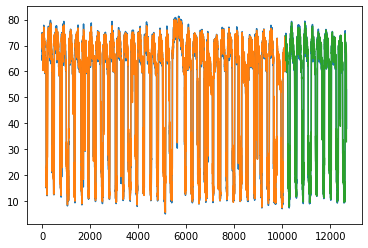

In [11]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test RMSE Score: %.2f RMSE' % (testScore))
mape = mean_absolute_percentage_error(testY[0], testPredict[:,0])
print('Test MAPE Score: %.3f MAPE' % (mape))

# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)

# plot the actual price, prediction in test data=red line, actual price=blue line
plt.plot(testPredictPlot)
plt.show()

testPrices=scaler.inverse_transform(dataset[test_size+look_back:])
testPrices = np.delete(testPrices, (0), axis=0)
# export prediction and actual prices
df = pd.DataFrame(data={"lstmprediction": np.around(list(testPredict.reshape(-1)), decimals=2), "lstmreal": np.around(list(testY.reshape(-1)), decimals=2)})
df.to_csv("lstm_result.csv", sep=',', index=None)

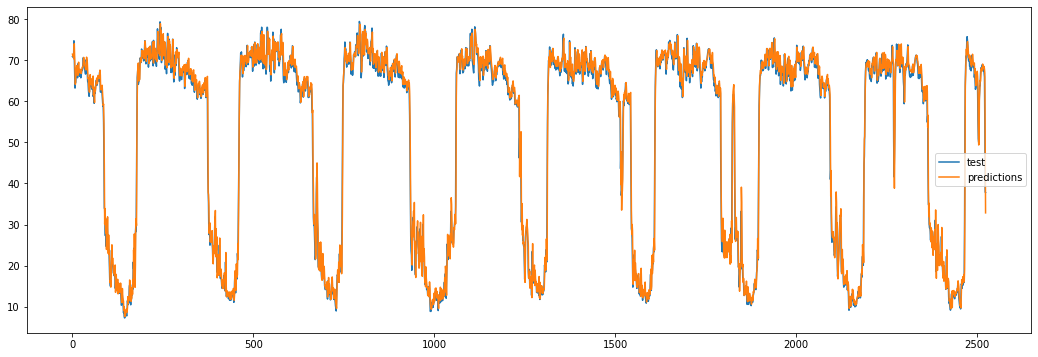

In [12]:
import numpy as np
import pandas as pd

fig, ax = plt.subplots(figsize=(18, 6))

Y_test1 = pd.DataFrame(testY.reshape(-1))
Y_pred_real1 = pd.DataFrame(testPredict.reshape(-1))

ax.plot(Y_test1, label='test')
ax.plot(Y_pred_real1, label='predictions')
ax.legend();